In [13]:
import numpy as np
from matplotlib import pyplot as plt

The Matplotlib Object Hierarchy
One important big-picture matplotlib concept is its object hierarchy.

If you’ve worked through any introductory matplotlib tutorial, you’ve probably called something like plt.plot([1, 2, 3]). This one-liner hides the fact that a plot is really a hierarchy of nested Python objects. A “hierarchy” here means that there is a tree-like structure of matplotlib objects underlying each plot.

A Figure object is the outermost container for a matplotlib graphic, which can contain multiple Axes objects. One source of confusion is the name: an Axes actually translates into what we think of as an individual plot or graph (rather than the plural of “axis,” as we might expect).

You can think of the Figure object as a box-like container holding one or more Axes (actual plots). Below the Axes in the hierarchy are smaller objects such as tick marks, individual lines, legends, and text boxes. Almost every “element” of a chart is its own manipulable Python object, all the way down to the ticks and labels:

matplotlib.figure.Figure

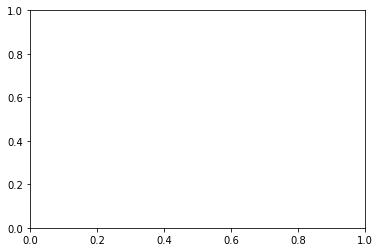

In [14]:
s= np.random.seed(444)
fig, _ = plt.subplots()
type(fig)

Above, we created two variables with plt.subplots(). The first is a top-level Figure object. The second is a “throwaway” variable that we don’t need just yet, denoted with an underscore. Using attribute notation, it is easy to traverse down the figure hierarchy and see the first tick of the y axis of the first Axes object:

In [15]:
one_tick = fig.axes[0].yaxis.get_major_ticks()[0]
type(one_tick)

matplotlib.axis.YTick

Above, fig (a Figure class instance) has multiple Axes (a list, for which we take the first element). Each Axes has a yaxis and xaxis, each of which have a collection of “major ticks,” and we grab the first one.

Stateful Versus Stateless Approaches

we need one more chunk of theory before we can get around to the shiny visualizations: the difference between the stateful (state-based, state-machine) and stateless (object-oriented, OO) interfaces.

Almost all functions from pyplot, such as plt.plot(), are implicitly either referring to an existing current Figure and current Axes, or creating them anew if none exist. Hidden in the matplotlib docs is this helpful snippet:

“[With pyplot], simple functions are used to add plot elements (lines, images, text, etc.) to the current axes in the current figure.

The stateful interface makes its calls with plt.plot() and other top-level pyplot functions. There is only ever one Figure or Axes that you’re manipulating at a given time, and you don’t need to explicitly refer to it.
Modifying the underlying objects directly is the object-oriented approach. We usually do this by calling methods of an Axes object, which is the object that represents a plot itself.

Tying these together, most of the functions from pyplot also exist as methods of the matplotlib.axes.Axes class.

This is easier to see by peeking under the hood. plt.plot() can be boiled down to five or so lines of code:

In [16]:
# matplotlib/pyplot.py
def plot(*args, **kwargs):
     """An abridged version of plt.plot()."""
     ax = plt.gca()
     return ax.plot(*args, **kwargs)

def gca(**kwargs):
    """Get the current Axes of the current Figure."""
    return plt.gcf().gca(**kwargs)

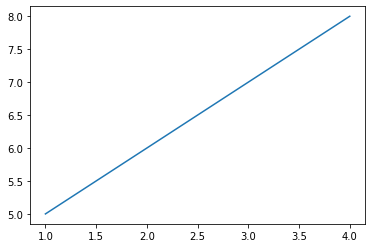

In [18]:
plot([1,2,3,4],[5,6,7,8])

Calling plt.plot() is just a convenient way to get the current Axes of the current Figure and then call its plot() method. This is what is meant by the assertion that the stateful interface always “implicitly tracks” the plot that it wants to reference.

pyplot is home to a batch of functions that are really just wrappers around matplotlib’s object-oriented interface. For example, with plt.title(), there are corresponding setter and getter methods within the OO approach, ax.set_title() and ax.get_title(). (Use of getters and setters tends to be more popular in languages such as Java but is a key feature of matplotlib’s OO approach.)

Calling plt.title() gets translated into this one line: gca().set_title(s, *args, **kwargs). Here’s what that is doing:

gca() grabs the current axis and returns it.
set_title() is a setter method that sets the title for that Axes object. The “convenience” here is that we didn’t need to specify any Axes object explicitly with plt.title().
Similarly, if you take a few moments to look at the source for top-level functions like plt.grid(), plt.legend(), and plt.ylabels(), you’ll notice that all of them follow the same structure of delegating to the current Axes with gca() and then calling some method of the current Axes. (This is the underlying object-oriented approach!)

Understanding plt.subplots() Notation

From here on out, we’ll mostly rely on the stateless (object-oriented) approach, which is more customizable and comes in handy as graphs become more complex.

The prescribed way to create a Figure with a single Axes under the OO approach is (not too intuitively) with plt.subplots(). This is really the only time that the OO approach uses pyplot, to create a Figure and Axes:

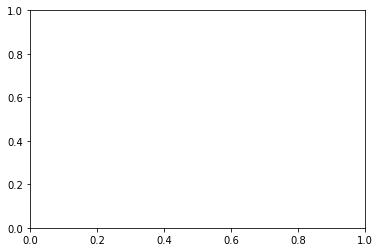

In [19]:
fig, ax = plt.subplots()

Above, we took advantage of iterable unpacking to assign a separate variable to each of the two results of plt.subplots(). Notice that we didn’t pass arguments to subplots() here. The default call is subplots(nrows=1, ncols=1). Consequently, ax is a single AxesSubplot object:

In [20]:
type(ax)

matplotlib.axes._subplots.AxesSubplot

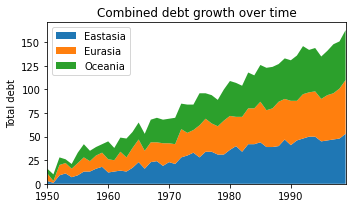

In [21]:
rng = np.arange(50)
rnd = np.random.randint(0, 10, size=(3, rng.size))
yrs = 1950 + rng

fig, ax = plt.subplots(figsize=(5, 3))
ax.stackplot(yrs, rng + rnd, labels=['Eastasia', 'Eurasia', 'Oceania'])
ax.set_title('Combined debt growth over time')
ax.legend(loc='upper left')
ax.set_ylabel('Total debt')
ax.set_xlim(xmin=yrs[0], xmax=yrs[-1])
fig.tight_layout()

Here’s what’s going on above:

After creating three random time series, we defined one Figure (fig) containing one Axes (a plot, ax).

We call methods of ax directly to create a stacked area chart and to add a legend, title, and y-axis label. Under the object-oriented approach, it’s clear that all of these are attributes of ax.

tight_layout() applies to the Figure object as a whole to clean up whitespace padding.

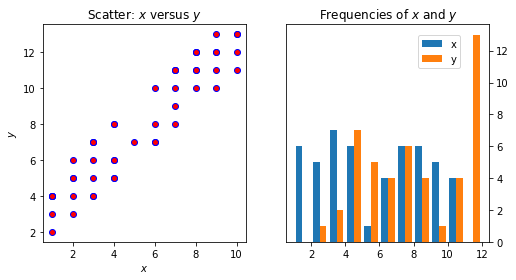

In [36]:
x = np.random.randint(low=1, high=11, size=50)
y = x + np.random.randint(1, 5, size=x.size)
data = np.column_stack((x, y))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,
                                figsize=(8, 4))

ax1.scatter(x=x, y=y, marker='o', c='r', edgecolor='b')
ax1.set_title('Scatter: $x$ versus $y$')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax2.hist(data, bins=np.arange(data.min(), data.max()),label=('x', 'y'))
ax2.legend(loc=(0.65, 0.8))
ax2.set_title('Frequencies of $x$ and $y$')
ax2.yaxis.tick_right()

There’s a little bit more going on in this example:

Because we’re creating a “1x2” Figure, the returned result of plt.subplots(1, 2) is now a Figure object and a NumPy array of Axes objects. (You can inspect this with fig, axs = plt.subplots(1, 2) and taking a look at axs.)

We deal with ax1 and ax2 individually, which would be difficult to do with the stateful approach. The final line is a good illustration of the object hierarchy, where we are modifying the yaxis belonging to the second Axes, placing its ticks and ticklabels to the right.

Text inside dollar signs utilizes TeX markup to put variables in italics.

Remember that multiple Axes can be enclosed in or “belong to” a given figure. In the case above, fig.axes gets us a list of all the Axes objects:


In [23]:
(fig.axes[0] is ax1, fig.axes[1] is ax2)

(True, True)

we could alternatively create a figure that holds a 2x2 grid of Axes objects:

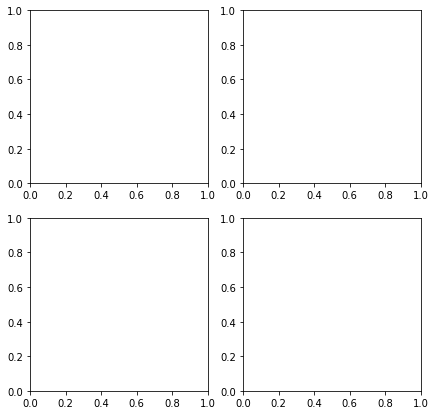

In [24]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))

In [25]:
type(ax)

numpy.ndarray

In [29]:
ax[0,0:]

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

In [30]:
ax.shape

(2, 2)

“ax can be either a single matplotlib.axes.Axes object or an array of Axes objects if more than one subplot was created.”

we now need to call plotting methods on each of these Axes (but not the NumPy array, which is just a container in this case). A common way to address this is to use iterable unpacking after flattening the array to be one-dimensional:

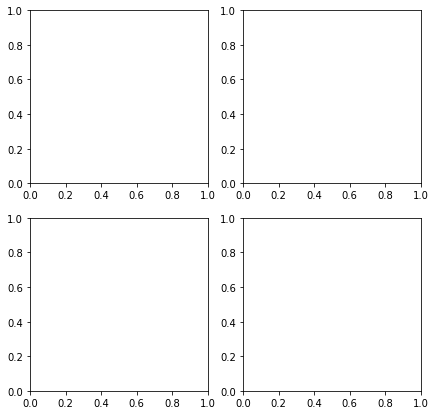

In [35]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))
ax1, ax2, ax3, ax4 = ax.flatten()

To illustrate some more advanced subplot features, let’s pull some macroeconomic California housing data extracted from a compressed tar archive, using io, tarfile, and urllib from Python’s Standard Library.


While ax.plot() is one of the most common plotting methods on an Axes, there are a whole host of others, as well. (We used ax.stackplot() above. 
Methods that get heavy use are imshow() and matshow(), with the latter being a wrapper around the former. These are useful anytime that a raw numerical array can be visualized as a colored grid.